In [1]:

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

## Dataset: Undergraduate Admission Test Survey in Bangladesh

The **"undergraduate-admission-test-survey-in-bangladesh"** dataset contains detailed information on students' academic performance and socioeconomic background in Bangladesh. It includes key features like secondary and higher secondary school grade points, along with family economic status. This data helps analyze factors that influence students' grade drops during their transition to higher secondary education, highlighting the role of socioeconomic conditions in academic outcomes.


In [11]:
df = pd.read_csv('/kaggle/input/undergraduate-admission-test-survey-in-bangladesh/Undergraduate Admission Test Survey in Bangladesh.csv')
df.head()

,SSC_GPA,HSC_GPA,Family_Economy,Residence,Family_Education,Politics,Social_Media_Engagement,Residence_with_Family,Duration_of_Study,College_Location,School_Location,Bad_Habits,Relationship,External_Factors,University
0,5.0,4.67,2,1,1,1,4,0,4,1,0,0,0,1,0
1,5.0,5.00,3,1,1,0,5,0,6,1,0,0,1,1,1
2,5.0,4.44,2,0,1,0,1,1,2,0,0,0,0,0,0
3,5.0,5.00,2,1,1,0,1,1,2,1,1,0,0,0,1
4,5.0,5.00,2,1,1,0,1,0,2,1,1,0,0,0,1


In [12]:
df.info()
df.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SSC_GPA                  600 non-null    float64
 1   HSC_GPA                  597 non-null    float64
 2   Family_Economy           600 non-null    int64  
 3   Residence                600 non-null    int64  
 4   Family_Education         600 non-null    int64  
 5   Politics                 600 non-null    int64  
 6   Social_Media_Engagement  600 non-null    int64  
 7   Residence_with_Family    600 non-null    int64  
 8   Duration_of_Study        600 non-null    int64  
 9   College_Location         600 non-null    int64  
 10  School_Location          600 non-null    int64  
 11  Bad_Habits               600 non-null    int64  
 12  Relationship             600 non-null    int64  
 13  External_Factors         600 non-null    int64  
 14  University               6

In [8]:
df['Social_Media_Engagement'].value_counts()

Social_Media_Engagement
3    246
1    174
4    112
5     65
Name: count, dtype: int64

## Data Exploration: Relationship between SSC and HSC GPA

To understand the relationship between students' performance in secondary school (SSC) and higher secondary school (HSC), I plotted a scatter plot of **SSC_GPA** (Secondary School Certificate GPA) against **HSC_GPA** (Higher Secondary School Certificate GPA).
I notice that despite the fact that most of the student raise in GPA some of them fall so i wanted to know why.


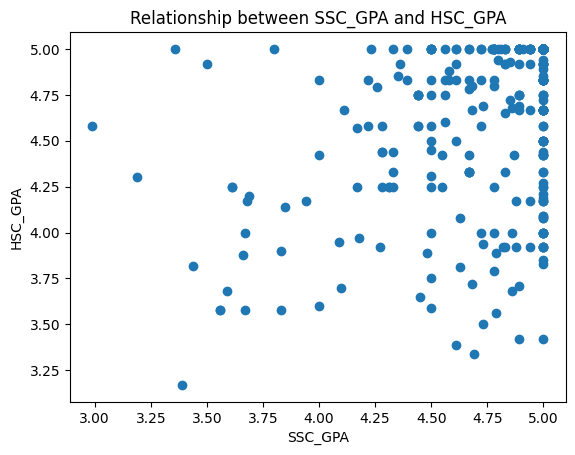

In [9]:
plt.scatter(df['SSC_GPA'], df["HSC_GPA"])
plt.xlabel("SSC_GPA")
plt.ylabel("HSC_GPA")
plt.title('Relationship between SSC_GPA and HSC_GPA');

# Analyzing GPA Changes between SSC and HSC

To further explore students' academic performance, I analyze the difference between their **HSC_GPA** (Higher Secondary School Certificate GPA) and **SSC_GPA** (Secondary School Certificate GPA). an categorized the changes into three groups: students whose GPA increased, remained the same, or decreased.

In [13]:
print('rise', df[df["HSC_GPA"]-df['SSC_GPA'] > 0].shape)
print('thesame',df[df["HSC_GPA"]-df['SSC_GPA'] == 0].shape)
print('drop', df[df["HSC_GPA"]-df['SSC_GPA'] < 0].shape)

rise (102, 15)
thesame (357, 15)
drop (138, 15)


## Creating the GPA Drop Indicator

To better analyze the decline in students' academic performance, I introduced a new column called **`GPA_drop`**. This column indicates whether a student's GPA dropped when transitioning from Secondary School Certificate (SSC) to Higher Secondary School Certificate (HSC).


In [15]:
df['GPA_drop'] = (df["HSC_GPA"]-df['SSC_GPA'] < 0).astype(int)

## Visualizing GPA Drop Class Distribution

To understand the balance between students who experienced a GPA drop and those who did not, I plotted the frequency distribution of the **`GPA_drop`** column.


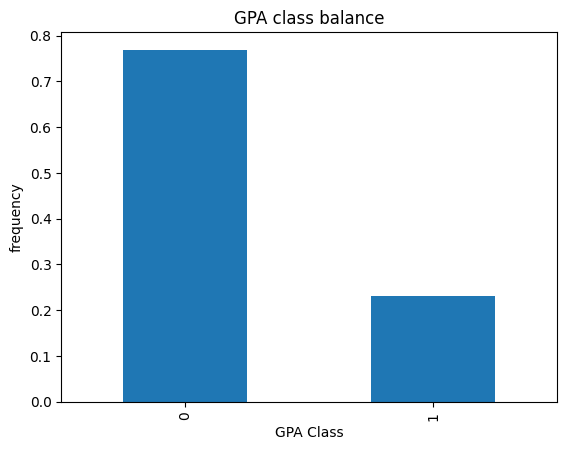

In [16]:
df['GPA_drop'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel("GPA Class")
plt.ylabel('frequency')
plt.title('GPA class balance');

## Correlation and GPA Drop Analysis

To gain deeper insights into the factors influencing GPA drops, I conducted two analyses: a correlation heatmap and a grouped bar chart illustrating the relationship between **`GPA_drop`** and **`Family_Economy`**.


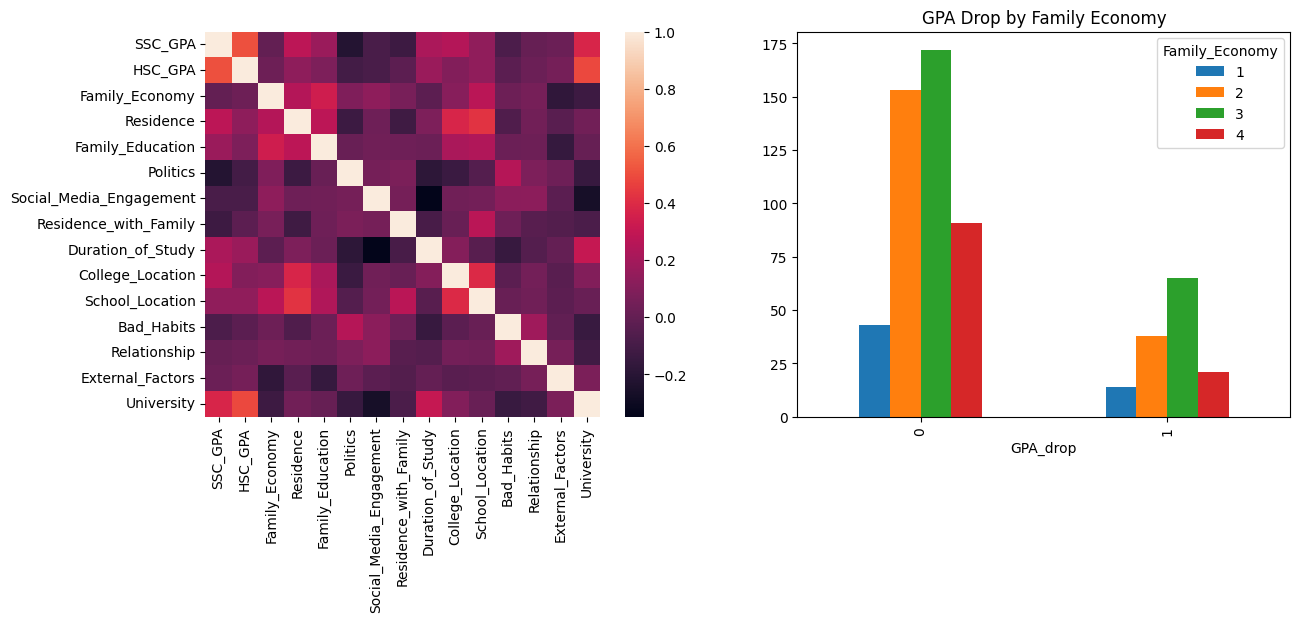

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(df.drop(columns="GPA_drop").corr(), ax=axes[0])
df.groupby(['GPA_drop', 'Family_Economy']).size().unstack().plot(kind='bar', ax=axes[1])
axes[1].set_title('GPA Drop by Family Economy');

## Preparing Data for Modeling

To focus on the relevant features for our classification model and eliminate potential leakage from the target variable, I dropped the **`HSC_GPA`** and **`SSC_GPA`** columns from the dataset.


In [21]:
df.drop(columns=['HSC_GPA', 'SSC_GPA'], inplace=True)

## Setting Up Features and Target Variable

To prepare for training our classification model, I defined the features and the target variable.


In [22]:
terget = 'GPA_drop'
X = df.drop(columns=terget)
y = df[terget]

## Splitting the Dataset into Training and Testing Sets

To evaluate the performance of our classification model, we split the dataset into training and testing sets.


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Calculating Baseline Accuracy

Before evaluating the performance of our classification model, I calculated the baseline accuracy, which serves as a reference point for model performance.


In [24]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.77


## Hyperparameter Tuning for Decision Tree

To optimize our classification model, I explored various values for the maximum depth of the decision tree and evaluated both training and validation accuracy scores.


In [25]:
depth_hyperparams = range(1, 50, 2)
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    test_model = DecisionTreeClassifier(max_depth=d, random_state=42)
    test_model.fit(X_train, y_train)
    training_acc.append(test_model.score(X_train, y_train ))
    validation_acc.append(test_model.score(X_test, y_test ))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.7693920335429769, 0.7987421383647799, 0.8322851153039832]
Validation Accuracy Scores: [0.7666666666666667, 0.8, 0.7583333333333333]


## Visualizing Training and Validation Accuracy

To evaluate the impact of different maximum depths on model performance, I plotted the training and validation accuracy scores. the plot shows that the best max_dept for our model is `4`


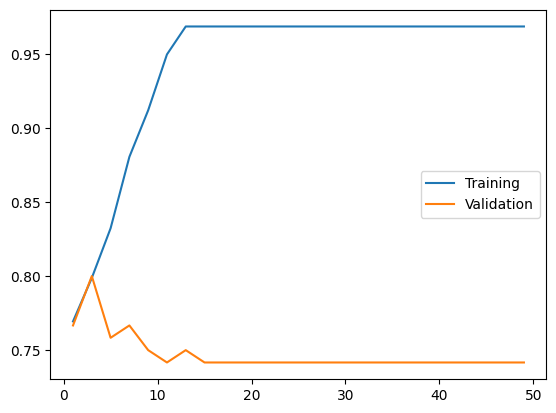

In [28]:
plt.plot(depth_hyperparams, training_acc, label="Training")
plt.plot(depth_hyperparams, validation_acc, label="Validation")
plt.legend();

## Building and Fitting the Decision Tree Model

After determining the optimal maximum depth for our decision tree, I proceeded to build the model and fit it to the training data.


In [29]:
# Build Model
model = DecisionTreeClassifier(max_depth=4, random_state=42)
# Fit model to training data
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

## Evaluating Model Performance

After fitting the decision tree model, we evaluated its accuracy on both the training and test datasets.


In [31]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_test, 2))

Training Accuracy: 0.82
Validation Accuracy: 0.81


## Analyzing Feature Importance

To understand which features play the most significant role in our decision tree model, I examined the feature importance scores.


In [34]:
features = X_train.columns
importances = model.feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['Family_Economy', 'Residence', 'Family_Education'], dtype='object')
Importances: [0.03992015 0.         0.04261924]


## Visualizing Feature Importance

To gain deeper insights into which features most influence the decision tree model's predictions, I visualized the feature importance scores using a horizontal bar plot.


Text(0, 0.5, 'Feature')

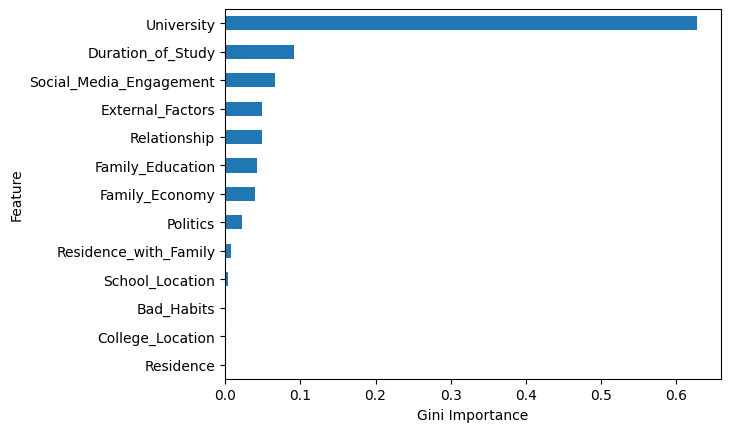

In [35]:
feat_imp = pd.Series(importances, index=features).sort_values(ascending=True)
feat_imp.head()
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature");

## Conclusion
Based on your feature importance plot, it appears that the feature related to `University` has the highest importance in the decision tree model. This means that, among all the features, the variable representing universities plays the most significant role in predicting whether a student's GPA drops when transitioning from secondary to higher secondary education.

